# FEDOT framework
#### FEDOT version = 0.6.2

In [1]:
pip install fedot==0.6.2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Below is a description of the FEDOT framework and its main functions, which can be used to solve various ML tasks, namely:

* Regression
* Classification
* Time series forecasting
* Clustering

FEDOT can construct complex composite models (consisting of multiple machine learning models and preprocessing operations) based on an evolutionary algorithm. Thus, it is possible to create pipelines for solving various tasks.

The structure of the FEDOT framework can be seen in the figure below:

<img src="../jupyter_media/fedot_structure/fedot_structure_04.png" width="800"/> 

Figure 1. The structure of the FEDOT framework. The main modules of the library are shown.

As you can see from the picture there are two ways to start FEDOT:
1) API - allows you to run framework models in a few lines of code;
2) Low-level methods from the core - you can call methods by accessing the core directly. In this case, you will have to write more code, but more functionality opens up.

## Composite models

FEDOT has following abstractions:
* Operation - is a machine learning model or preprocessing operation or statistical models;
* Node - is a container in which the operation is placed. A single node can contain only one operation;
* Pipeline - is directed acyclic graph-like structure that contains several connected nodes. The analogue can be a computation graph from tensorflow, or simple workflow (from Apache Airflow, for instance). Pipelines are complex composite models. A single pipeline can consist of multiple nodes, or a single node.

<img src="../jupyter_media/fedot_structure/operation_node_pipeline.png" width="800"/> 

## Generate synthetic dataset for classification task

In [1]:
import logging
logging.raiseExceptions = False

from fedot.utilities.synth_dataset_generator import classification_dataset
from sklearn.metrics import roc_auc_score as roc_auc

# Generate numpy arrays with features and target
features_options = {'informative': 1, 'redundant': 0,
                    'repeated': 0, 'clusters_per_class': 1}
x_data, y_data = classification_dataset(samples_amount=250,
                                        features_amount=3,
                                        classes_amount=2,
                                        features_options=features_options)

print(f'Features table shape: {x_data.shape}, type: {type(x_data)}')
print(f'Target vector: {y_data.shape}, type: {type(y_data)}')

Features table shape: (250, 3), type: <class 'numpy.ndarray'>
Target vector: (250,), type: <class 'numpy.ndarray'>


Prepare the necessary imports

In [2]:
import numpy as np

# Create pipelines
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

# Tasks to solve
from fedot.core.repository.tasks import Task, TaskTypesEnum

# Dataclass for wrapping arrays into it
from fedot.core.data.data import InputData

# Type of the input data
from fedot.core.repository.dataset_types import DataTypesEnum

# Define classification task
task = Task(TaskTypesEnum.classification)

# Prepare data to train the model
input_data = InputData(idx=np.arange(0, len(x_data)), features=x_data,
                       target=y_data, task=task,
                       data_type=DataTypesEnum.table)

## Manual pipeline 

Below, we will try to set the pipeline manually, and obtain a prediction using it.

Manually create a pipeline with the following configuration:

![logit_scaling_lda.png](../jupyter_media/fedot_structure/logit_scaling_lda.png)

In [3]:
# Define pipeline 
node_logit = PrimaryNode('logit')
node_scaling = PrimaryNode('scaling')
node_logit = SecondaryNode('lda', nodes_from=[node_logit, node_scaling])
pipeline = Pipeline(node_logit)

# Fit it
pipeline.fit(input_data)

# Make prediction
predicted_output = pipeline.predict(input_data)
probs = np.array(predicted_output.predict)

# Check metric value
print(f'ROC AUC score on training sample: {roc_auc(y_data, probs):.3f}')

c:\users\valery\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ROC AUC score on training sample: 0.898


This is how you learned the concept of pipelines in FEDOT.

But FEDOT can automatically construct such pipelines to solve the task.

Below are two examples for solving the classification task (with such pipelines) using API methods and using FEDOT.core function directly. Both examples, regardless of the way they interact, run an automatic machine learning algorithm.

## AutoML

### API example

Using the API allows you to find good solutions using a few lines of code, but on the other hand, this approach has less abilities for modification than using core-based methods.

In [4]:
from fedot.api.main import Fedot

# Task selection, initialisation of the framework
fedot_model = Fedot(problem='classification', 
                    timeout=1, preset='fast_train',
                    seed=20, logging_level=0)

# During fit, the pipeline composition algorithm is started
pipeline = fedot_model.fit(features=x_data,
                           target=y_data)

2023-02-21 21:55:26,004 - AssumptionsHandler - Initial pipeline fitting started
2023-02-21 21:55:26,374 - AssumptionsHandler - Initial pipeline was fitted successfully
2023-02-21 21:55:26,375 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.4 MiB, max: 1.3 MiB
2023-02-21 21:55:26,376 - ApiComposer - Initial pipeline was fitted in 0.4 sec.
2023-02-21 21:55:26,381 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['knn', 'bernb', 'logit', 'qda', 'rf', 'pca', 'dt', 'scaling', 'normalization', 'knn', 'bernb', 'logit', 'qda', 'rf', 'pca', 'dt', 'scaling', 'normalization'].
2023-02-21 21:55:26,386 - ApiComposer - Pipeline composition started.
2023-02-21 21:55:26,388 - DataSourceSplitter - K-folds cross validation is applied.


Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-02-21 21:55:26,392 - MultiprocessingDispatcher - Number of used CPU's: 12
2023-02-21 21:55:31,657 - MultiprocessingDispatcher - Memory consumption for parallel evaluation of population in main session: current 0.7 MiB, max: 1.3 MiB
2023-02-21 21:55:31,660 - EvoGraphOptimizer - Generation num: 1
2023-02-21 21:55:31,661 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.863 ComplexityMetricsEnum.node_num=0.200>']
2023-02-21 21:55:32,653 - MultiprocessingDispatcher - Number of used CPU's: 12
2023-02-21 21:55:42,392 - MultiprocessingDispatcher - Memory consumption for parallel evaluation of population in main session: current 2.2 MiB, max: 2.2 MiB
2023-02-21 21:55:42,394 - EvoGraphOptimizer - Generation num: 2
2023-02-21 21:55:42,395 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.895 ComplexityMetricsEnum.node_num=0.200>']
2023-02-21 21:55:42,396 

Generations:   0%|                                                                          | 1/10000 [00:36<?, ?gen/s]

2023-02-21 21:56:02,772 - OptimisationTimer - Composition time: 0.606 min
2023-02-21 21:56:02,773 - OptimisationTimer - Algorithm was terminated due to processing time limit
2023-02-21 21:56:02,774 - EvoGraphOptimizer - Generation num: 8
2023-02-21 21:56:02,776 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.895 ComplexityMetricsEnum.node_num=0.200>']
2023-02-21 21:56:02,776 - EvoGraphOptimizer - no improvements for 6 iterations
2023-02-21 21:56:02,779 - EvoGraphOptimizer - spent time: 0.6 min
2023-02-21 21:56:02,782 - GPComposer - GP composition finished
2023-02-21 21:56:02,785 - DataSourceSplitter - K-folds cross validation is applied.
2023-02-21 21:56:02,788 - ApiComposer - Hyperparameters tuning started with 0 min. timeout
2023-02-21 21:56:02,789 - PipelineTuner - Hyperparameters optimization start: estimation of metric for initial pipeline
2023-02-21 21:56:02,873 - PipelineTuner - Initial pipeline: {'depth': 2,

2023-02-21 21:56:02,960 - TPE using 1/1 trials with best loss -0.895406
  0%|                                          | 2/100000 [00:00<2:15:01, 12.34trial/s, best loss: -0.8954056000000001]2023-02-21 21:56:03,042 - build_posterior_wrapper took 0.000998 seconds
2023-02-21 21:56:03,044 - TPE using 2/2 trials with best loss -0.895406
2023-02-21 21:56:03,127 - build_posterior_wrapper took 0.000986 seconds
2023-02-21 21:56:03,129 - TPE using 3/3 trials with best loss -0.895406
  0%|                                          | 4/100000 [00:00<2:17:57, 12.08trial/s, best loss: -0.8954056000000001]2023-02-21 21:56:03,211 - build_posterior_wrapper took 0.001005 seconds
2023-02-21 21:56:03,212 - TPE using 4/4 trials with best loss -0.895406
2023-02-21 21:56:03,289 - build_posterior_wrapper took 0.001000 seconds
2023-02-21 21:56:03,291 - TPE using 5/5 trials with best loss -0.895406
  0%|                                          | 6/100000 [00:00<2:16:37, 12.20trial/s, best loss: -0.895405600000

2023-02-21 21:56:06,373 - TPE using 41/41 trials with best loss -0.897002
  0%|                                         | 42/100000 [00:03<2:26:26, 11.38trial/s, best loss: -0.8970024000000001]2023-02-21 21:56:06,459 - build_posterior_wrapper took 0.000993 seconds
2023-02-21 21:56:06,461 - TPE using 42/42 trials with best loss -0.897002
2023-02-21 21:56:06,549 - build_posterior_wrapper took 0.000999 seconds
2023-02-21 21:56:06,551 - TPE using 43/43 trials with best loss -0.897002
  0%|                                         | 44/100000 [00:03<2:27:44, 11.28trial/s, best loss: -0.8970024000000001]2023-02-21 21:56:06,640 - build_posterior_wrapper took 0.001000 seconds
2023-02-21 21:56:06,642 - TPE using 44/44 trials with best loss -0.897002
2023-02-21 21:56:06,725 - build_posterior_wrapper took 0.001004 seconds
2023-02-21 21:56:06,727 - TPE using 45/45 trials with best loss -0.897002
  0%|                                         | 46/100000 [00:03<2:27:57, 11.26trial/s, best loss: -0.89

2023-02-21 21:56:09,854 - TPE using 81/81 trials with best loss -0.897002
  0%|                                         | 82/100000 [00:07<2:20:54, 11.82trial/s, best loss: -0.8970024000000001]2023-02-21 21:56:09,936 - build_posterior_wrapper took 0.001007 seconds
2023-02-21 21:56:09,937 - TPE using 82/82 trials with best loss -0.897002
2023-02-21 21:56:10,025 - build_posterior_wrapper took 0.001000 seconds
2023-02-21 21:56:10,028 - TPE using 83/83 trials with best loss -0.898000
  0%|                                         | 84/100000 [00:07<2:22:36, 11.68trial/s, best loss: -0.8980004000000001]2023-02-21 21:56:10,112 - build_posterior_wrapper took 0.001012 seconds
2023-02-21 21:56:10,114 - TPE using 84/84 trials with best loss -0.898000
2023-02-21 21:56:10,196 - build_posterior_wrapper took 0.000992 seconds
2023-02-21 21:56:10,198 - TPE using 85/85 trials with best loss -0.898000
  0%|                                         | 86/100000 [00:07<2:21:57, 11.73trial/s, best loss: -0.89

2023-02-21 21:56:13,289 - TPE using 121/121 trials with best loss -0.898998
  0%|                                                 | 122/100000 [00:10<2:21:37, 11.75trial/s, best loss: -0.8989984]2023-02-21 21:56:13,375 - build_posterior_wrapper took 0.002015 seconds
2023-02-21 21:56:13,376 - TPE using 122/122 trials with best loss -0.898998
2023-02-21 21:56:13,460 - build_posterior_wrapper took 0.001012 seconds
2023-02-21 21:56:13,462 - TPE using 123/123 trials with best loss -0.898998
  0%|                                                 | 124/100000 [00:10<2:21:35, 11.76trial/s, best loss: -0.8989984]2023-02-21 21:56:13,543 - build_posterior_wrapper took 0.001014 seconds
2023-02-21 21:56:13,545 - TPE using 124/124 trials with best loss -0.898998
2023-02-21 21:56:13,627 - build_posterior_wrapper took 0.001003 seconds
2023-02-21 21:56:13,628 - TPE using 125/125 trials with best loss -0.898998
  0%|                                                 | 126/100000 [00:10<2:21:34, 11.76trial/

2023-02-21 21:56:16,663 - build_posterior_wrapper took 0.001007 seconds
2023-02-21 21:56:16,665 - TPE using 161/161 trials with best loss -0.898998
  0%|                                                 | 162/100000 [00:13<2:20:04, 11.88trial/s, best loss: -0.8989984]2023-02-21 21:56:16,748 - build_posterior_wrapper took 0.000000 seconds
2023-02-21 21:56:16,751 - TPE using 162/162 trials with best loss -0.898998
2023-02-21 21:56:16,832 - build_posterior_wrapper took 0.001004 seconds
2023-02-21 21:56:16,834 - TPE using 163/163 trials with best loss -0.898998
  0%|                                                 | 164/100000 [00:14<2:19:44, 11.91trial/s, best loss: -0.8989984]2023-02-21 21:56:16,915 - build_posterior_wrapper took 0.001005 seconds
2023-02-21 21:56:16,917 - TPE using 164/164 trials with best loss -0.898998
2023-02-21 21:56:16,998 - build_posterior_wrapper took 0.000996 seconds
2023-02-21 21:56:17,000 - TPE using 165/165 trials with best loss -0.898998
  0%|                 

2023-02-21 21:56:19,966 - TPE using 200/200 trials with best loss -0.898998
2023-02-21 21:56:20,047 - build_posterior_wrapper took 0.001000 seconds
2023-02-21 21:56:20,049 - TPE using 201/201 trials with best loss -0.898998
  0%|                                                 | 202/100000 [00:17<2:21:57, 11.72trial/s, best loss: -0.8989984]2023-02-21 21:56:20,136 - build_posterior_wrapper took 0.001004 seconds
2023-02-21 21:56:20,138 - TPE using 202/202 trials with best loss -0.898998
2023-02-21 21:56:20,223 - build_posterior_wrapper took 0.001004 seconds
2023-02-21 21:56:20,225 - TPE using 203/203 trials with best loss -0.898998
  0%|                                                 | 204/100000 [00:17<2:23:17, 11.61trial/s, best loss: -0.8989984]2023-02-21 21:56:20,311 - build_posterior_wrapper took 0.001002 seconds
2023-02-21 21:56:20,314 - TPE using 204/204 trials with best loss -0.898998
2023-02-21 21:56:20,405 - build_posterior_wrapper took 0.001000 seconds
2023-02-21 21:56:20,40

  0%|                                                 | 240/100000 [00:20<2:21:02, 11.79trial/s, best loss: -0.8989984]2023-02-21 21:56:23,451 - build_posterior_wrapper took 0.000000 seconds
2023-02-21 21:56:23,454 - TPE using 240/240 trials with best loss -0.898998
2023-02-21 21:56:23,535 - build_posterior_wrapper took 0.001000 seconds
2023-02-21 21:56:23,537 - TPE using 241/241 trials with best loss -0.898998
  0%|                                                 | 242/100000 [00:20<2:21:22, 11.76trial/s, best loss: -0.8989984]2023-02-21 21:56:23,623 - build_posterior_wrapper took 0.001007 seconds
2023-02-21 21:56:23,625 - TPE using 242/242 trials with best loss -0.898998
2023-02-21 21:56:23,707 - build_posterior_wrapper took 0.001007 seconds
2023-02-21 21:56:23,709 - TPE using 243/243 trials with best loss -0.898998
  0%|                                                 | 244/100000 [00:20<2:21:22, 11.76trial/s, best loss: -0.8989984]2023-02-21 21:56:23,793 - build_posterior_wrapper t

In [5]:
pipeline.print_structure()

Pipeline structure:
{'depth': 2, 'length': 2, 'nodes': [logit, scaling]}
logit - {'C': 0.024528559641643247}
scaling - {}


2023-02-21 21:56:26,081 - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-02-21 21:56:26,085 - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-02-21 21:56:26,088 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-02-21 21:56:26,089 - findfont: score(FontEntry(fname='c:\\users\\valery\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,091 - findfont: score(FontEntry(fname='c:\\users\\valery\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,092 - findfont: score(FontEntry(fname='c:\\users\

2023-02-21 21:56:26,113 - findfont: score(FontEntry(fname='c:\\users\\valery\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
2023-02-21 21:56:26,114 - findfont: score(FontEntry(fname='c:\\users\\valery\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,115 - findfont: score(FontEntry(fname='c:\\users\\valery\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-02-21 21:56:26,116 - findfont: score(FontEntry(fname='c:\\users\\valery\\appd

2023-02-21 21:56:26,142 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taileb.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-02-21 21:56:26,143 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebuc.ttf', name='Trebuchet MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,144 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariali.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 7.413636363636363
2023-02-21 21:56:26,145 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothR.ttc', name='Yu Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,146 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candara.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='s

2023-02-21 21:56:26,175 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriai.ttf', name='Cambria', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2023-02-21 21:56:26,176 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\pala.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,177 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ebrimabd.ttf', name='Ebrima', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-02-21 21:56:26,178 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriaz.ttf', name='Cambria', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2023-02-21 21:56:26,179 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comic.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')

2023-02-21 21:56:26,208 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consolai.ttf', name='Consolas', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2023-02-21 21:56:26,209 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Sitka.ttc', name='Sitka Small', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,209 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaZ.ttc', name='Sitka Small', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2023-02-21 21:56:26,210 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-02-21 21:56:26,211 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', si

2023-02-21 21:56:26,267 - top of Axes not in the figure, so title not moved
2023-02-21 21:56:26,269 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2023-02-21 21:56:26,270 - findfont: score(FontEntry(fname='c:\\users\\valery\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,270 - findfont: score(FontEntry(fname='c:\\users\\valery\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,271 - findfont: score(FontEntry(fname='c:\\users\\valery\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name

2023-02-21 21:56:26,290 - findfont: score(FontEntry(fname='c:\\users\\valery\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
2023-02-21 21:56:26,291 - findfont: score(FontEntry(fname='c:\\users\\valery\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,292 - findfont: score(FontEntry(fname='c:\\users\\valery\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-02-21 21:56:26,293 - findfont: score(FontEntry(fname='c:\\users\\valery\\appd

2023-02-21 21:56:26,319 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taileb.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-02-21 21:56:26,320 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebuc.ttf', name='Trebuchet MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,320 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariali.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 7.413636363636363
2023-02-21 21:56:26,321 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothR.ttc', name='Yu Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,322 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candara.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='s

2023-02-21 21:56:26,355 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriai.ttf', name='Cambria', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2023-02-21 21:56:26,355 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\pala.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,356 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ebrimabd.ttf', name='Ebrima', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-02-21 21:56:26,357 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriaz.ttf', name='Cambria', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2023-02-21 21:56:26,358 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comic.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')

2023-02-21 21:56:26,387 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consolai.ttf', name='Consolas', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2023-02-21 21:56:26,387 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Sitka.ttc', name='Sitka Small', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-02-21 21:56:26,389 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaZ.ttc', name='Sitka Small', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2023-02-21 21:56:26,389 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-02-21 21:56:26,390 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', si

2023-02-21 21:56:26,432 - top of Axes not in the figure, so title not moved
2023-02-21 21:56:26,437 - top of Axes not in the figure, so title not moved
2023-02-21 21:56:26,445 - top of Axes not in the figure, so title not moved
2023-02-21 21:56:26,452 - top of Axes not in the figure, so title not moved


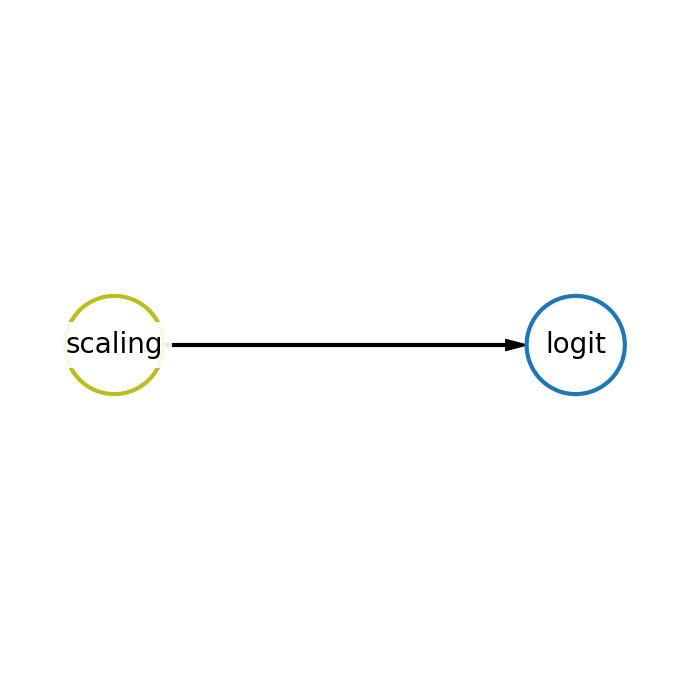

In [6]:
pipeline.show()

In [7]:
prediction = fedot_model.predict_proba(features=x_data)
print(pipeline)
print(f'ROC AUC score on training sample: {roc_auc(y_data, prediction):.3f}')

{'depth': 2, 'length': 2, 'nodes': [logit, scaling]}
ROC AUC score on training sample: 0.900


### Core-based example

We will transform the data into a specific format (InputData) for the algorithm launch.

In [8]:
import datetime
import numpy as np 

# Dataclass for wrapping arrays into it
from fedot.core.data.data import InputData

# Tasks to solve
from fedot.core.repository.tasks import Task, TaskTypesEnum

# Type of the input data
from fedot.core.repository.dataset_types import DataTypesEnum

# Repository with operations in the FEDOT
from fedot.core.repository.operation_types_repository import get_operations_for_task

# Pipeline of the FEDOT
from fedot.core.pipelines.pipeline import Pipeline

# Evolutionary algorithm classes 
from fedot.core.composer.composer_builder import ComposerBuilder
from fedot.core.composer.gp_composer.gp_composer import PipelineComposerRequirements
from fedot.core.optimisers.gp_comp.gp_params import GPGraphOptimizerParameters
from fedot.core.optimisers.gp_comp.operators.inheritance import GeneticSchemeTypesEnum
from fedot.core.repository.quality_metrics_repository import ClassificationMetricsEnum

Let's define the task that we plan to solve - classification

We will also wrap the data in a special structure-Input Data, where we will assign features, specify target, pass the data type (table) and the specified type of the task to be solved.

In [9]:
# Define classification task
task = Task(TaskTypesEnum.classification)

# Prepare data to train the model
input_data = InputData(idx=np.arange(0, len(x_data)), features=x_data,
                       target=y_data, task=task,
                       data_type=DataTypesEnum.table)

Now we have identified the data and the task within which we will look for a solution.

Next, we want to find a composite model (pipeline) of such a structure that predicts class labels as accurately as possible. We can determine from which models we can assemble such pipelines.

In [10]:
# The search of the models provided by the framework that can be used as nodes in a pipeline for the selected task
available_model_types = ['scaling', 'bernb', 'dt', 'knn', 'lda', 'logit', 'mlp', 'qda', 'rf', 'xgboost']

Let's set the metric that we will use during the evolution process, select "ROCAUC_penalty"

In [11]:
# The choice of the metric for the pipeline quality assessment during composition
metric_function = ClassificationMetricsEnum.ROCAUC_penalty

#### Composer

Composer is a genetic algorithm that allows you to search for optimal solutions by composing the pipelines of single machine learning models. 

Through PipelineComposerRequirements, we can set some hyperparameters to adjust the behavior of the evolutionary algorithm.

With the help of PipelineComposerRequirements, you can manage:
* types of models that can be inserted into primary nodes
* types of models that can be inserted into secondary nodes

* arity of directed acyclic graph (DAG)
* maximum depth of the found pipeline
* time to find a solution

In [12]:
# The choice and initialisation of the GP search
timeout = datetime.timedelta(minutes=1)
composer_requirements = PipelineComposerRequirements(
    primary=available_model_types,
    secondary=available_model_types, 
    max_arity=3,
    max_depth=3, 
    timeout=timeout,
    cv_folds=2)

Below we will define the genetic scheme of the algorithm. 

There are several schemes:
* steady_state - evolutionary scheme, also known as $(\mu+\lambda)$. New population is generated by using a selection operator which is applied to the union of the offspring and the previous population;
* generational - the offspring completely replaces the parent population;
* parameter_free - steady-state evolutionary scheme, but $\mu$ (population size) changes during evolution like the Fibonacci sequence and $\lambda$ always equals to the previous item of the sequence with respect to $\mu$.

For more information you can check [preprint](https://arxiv.org/abs/2103.01301).

We will also use the GPComposerBuilder structure, which allows you to set parameters in GPComposer.


In [13]:
from fedot.core.composer.gp_composer.specific_operators import parameter_change_mutation
from fedot.core.optimisers.gp_comp.operators.mutation import MutationTypesEnum

In [ ]:
# GP optimiser parameters choice
scheme_type = GeneticSchemeTypesEnum.parameter_free
mutation_types = [parameter_change_mutation, MutationTypesEnum.growth, MutationTypesEnum.reduce, MutationTypesEnum.simple]
graph_opt_params = GPGraphOptimizerParameters(
    genetic_scheme_type=scheme_type,
    mutation_types=mutation_types,
    crossover_prob=0.8,
    mutation_prob=0.8)

# Create builder for composer and set composer params
builder = ComposerBuilder(task=task).\
    with_requirements(composer_requirements).\
    with_optimizer_params(graph_opt_params).\
    with_metrics(metric_function)

# Create GP-based composer
composer = builder.build()

# the optimal pipeline generation by composition - the most time-consuming task
pipeline_evo_composed = composer.compose_pipeline(data=input_data)
pipeline_evo_composed.show()

2023-02-21 21:56:27,235 - DataSourceSplitter - K-folds cross validation is applied.


Generations: 1gen [00:00, ?gen/s]

2023-02-21 21:56:27,238 - MultiprocessingDispatcher - Number of used CPU's: 12
2023-02-21 21:56:29,737 - EvoGraphOptimizer - Generation num: 1
2023-02-21 21:56:29,738 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.886 ComplexityMetricsEnum.node_num=0.600>']
2023-02-21 21:56:29,794 - MultiprocessingDispatcher - Number of used CPU's: 12
2023-02-21 21:56:30,419 - EvoGraphOptimizer - Generation num: 2
2023-02-21 21:56:30,420 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.886 ComplexityMetricsEnum.node_num=0.600>']
2023-02-21 21:56:30,420 - EvoGraphOptimizer - no improvements for 1 iterations
2023-02-21 21:56:30,421 - EvoGraphOptimizer - spent time: 0.1 min
2023-02-21 21:56:30,421 - EvoGraphOptimizer - Next population size: 34; max graph depth: 3
2023-02-21 21:56:31,095 - MultiprocessingDispatcher - Number of used CPU's: 12
2023-02-21 21:56:33,610 -

We got a pipeline of several machine learning models. But in the course of evolution, the hyperparameters of these models did not change. Now, within the given topology, we will optimize the hyperparameters.

In [ ]:
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.repository.quality_metrics_repository import  ClassificationMetricsEnum


tuner = TunerBuilder(input_data.task)\
        .with_tuner(PipelineTuner)\
        .with_metric(ClassificationMetricsEnum.ROCAUC)\
        .with_iterations(20) \
        .build(input_data)
tuned_pipeline = tuner.tune(pipeline_evo_composed)

#final fit on all data
tuned_pipeline.fit(input_data)

Check the metric

In [ ]:
prediction = tuned_pipeline.predict(input_data)
print(f'ROC AUC score on training sample: {roc_auc(input_data.target, prediction.predict):.3f}')

As you can see from the metric value, the model was well trained on the training sample. 

### Pipeline visualistion 

In [ ]:
tuned_pipeline.show()

So, in this notebook, you learned how to run FEDOT for the classification task, both using the API and using more complex constructs from the core based on the functionality of the FEDOT framework.